In [7]:
# !wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null
# !tar xvzf ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null

# import os

# os.chdir('ta-lib') # Can't use !cd in co-lab

# !./configure --prefix=/usr 2>&1 > /dev/null
# !make 2>&1 > /dev/null
# !make install 2>&1 > /dev/null

# os.chdir('../')

# !pip install TA-Lib 2>&1 > /dev/null

./configure: line 4354: /usr/bin/file: No such file or directory
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
libtool: link: warning: `-version-info/-version-number' is ignored for convenience libraries
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
gen_code.c: In function ‘printFuncHeaderDoc’:
gen_code.c:3456:4: warning: format not a string literal and no format arguments [-Wformat-security]
    fprintf( out, prefix );
    ^~~~~~~


In [5]:
# !pip install yfinance

     |████████████████████████████████| 6.3 MB 8.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
from pandas.core.frame import DataFrame
import yfinance as yf
import numpy as np
import talib as ta
import pandas as pd

In [2]:
def get_score(df: DataFrame, indicator: str, entry_type='long'):
	indicator = indicator.upper()
 
	if indicator == 'RSI' and entry_type == 'long':
		try:
			rsiValue = df.rsi.head(1).values[0]
			if rsiValue in range(60,70):
				return 5
			elif rsiValue in range(70,80):
				return 4
			elif rsiValue >= 80:
				return 3
			elif rsiValue in range(50,60):
				return 2
			else:
				return 0
		except IndexError:
			return 0
	if indicator == 'MACD' and entry_type == 'long':
		macd = df.macd_crossover
		try:
			date = macd.iloc[list(np.where(df["macd_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA' and entry_type == 'long':
		try:
			date = df.ema_crossover.iloc[list(np.where(df["ema_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'VOLUME' and entry_type == 'long':
		try:
			date = df.volume_buy.iloc[list(np.where(df["volume_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	return None

In [3]:
data = pd.read_csv('INFY.csv')
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-21,963.049988,963.450012,946.549988,948.799988,928.694214,6513773
2020-08-24,947.000000,952.000000,939.200012,947.400024,927.323975,5798574
2020-08-25,947.500000,948.650024,933.599976,938.099976,918.220947,6233918
2020-08-26,941.250000,954.250000,938.400024,950.799988,930.651855,5153601
2020-08-27,960.000000,960.950012,945.200012,947.049988,926.981323,6154280


In [4]:
#data = DataFrame(yf.download('BTC-USD','2016-01-01',current_date))

In [5]:
data = data.drop(['Adj Close'], axis = 1)

In [6]:
data['5EMA'] = pd.Series.ewm(data['Close'], span=5).mean()

data['26EMA'] = pd.Series.ewm(data['Close'], span=26).mean()

data['rsi'] = ta.RSI(data['Close'].values, timeperiod=14)

data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(data.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)

data['macd_crossover'] = np.where(((data.macd > data.macdSignal) & (data.macd.shift(1) < data.macdSignal.shift(1))), 1, 0)
data['macd_crossunder'] = np.where(((data.macd < data.macdSignal) & (data.macd.shift(1) > data.macdSignal.shift(1))), 1, 0)
data['ema_crossover'] = np.where(((data['5EMA'].shift(1) <= data['26EMA'].shift(1)) & (data['5EMA'] > data['26EMA'] )), 1, 0)
data['ema_crossunder'] = np.where(((data['5EMA'].shift(1) >= data['26EMA'].shift(1)) & (data['5EMA'] < data['26EMA'] )), 1, 0)

data['rsi_buy'] = np.where(data.rsi > 60, 1, 0)
data['rsi_sell'] = np.where(data.rsi < 40, 1, 0)

data['volume_buy'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close > data.Close.shift(1)), 1, 0)
data['volume_sell'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close < data.Close.shift(1)), 1, 0)

last_week_data = data.tail(5).sort_values(by='Date', ascending=False)
rsiScore = get_score(last_week_data, indicator='rsi')
macdScore = get_score(last_week_data, indicator='macd')
emaScore = get_score(last_week_data, indicator='ema')
volumeScore = get_score(last_week_data, indicator='volume')
totalScore = rsiScore + macdScore + emaScore + volumeScore

/tmp/ipykernel_49019/3700509915.py:48: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:


In [7]:
totalScoreL = [0,0,0,0,0]
for i in range(len(data.index.values)-5):
	df = data[i:i+5]
	rsiScore = get_score(df, indicator='rsi')
	macdScore = get_score(df, indicator='macd')
	emaScore = get_score(df, indicator='ema')
	volumeScore = get_score(df, indicator='volume')
	totalScore = rsiScore + macdScore + emaScore + volumeScore
	totalScoreL.append(totalScore)

/tmp/ipykernel_49019/3700509915.py:37: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:
/tmp/ipykernel_49019/3700509915.py:48: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:
/tmp/ipykernel_49019/3700509915.py:26: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.to_datetime(dates[i]).date() == date:


In [8]:
data['totalScore'] = totalScoreL

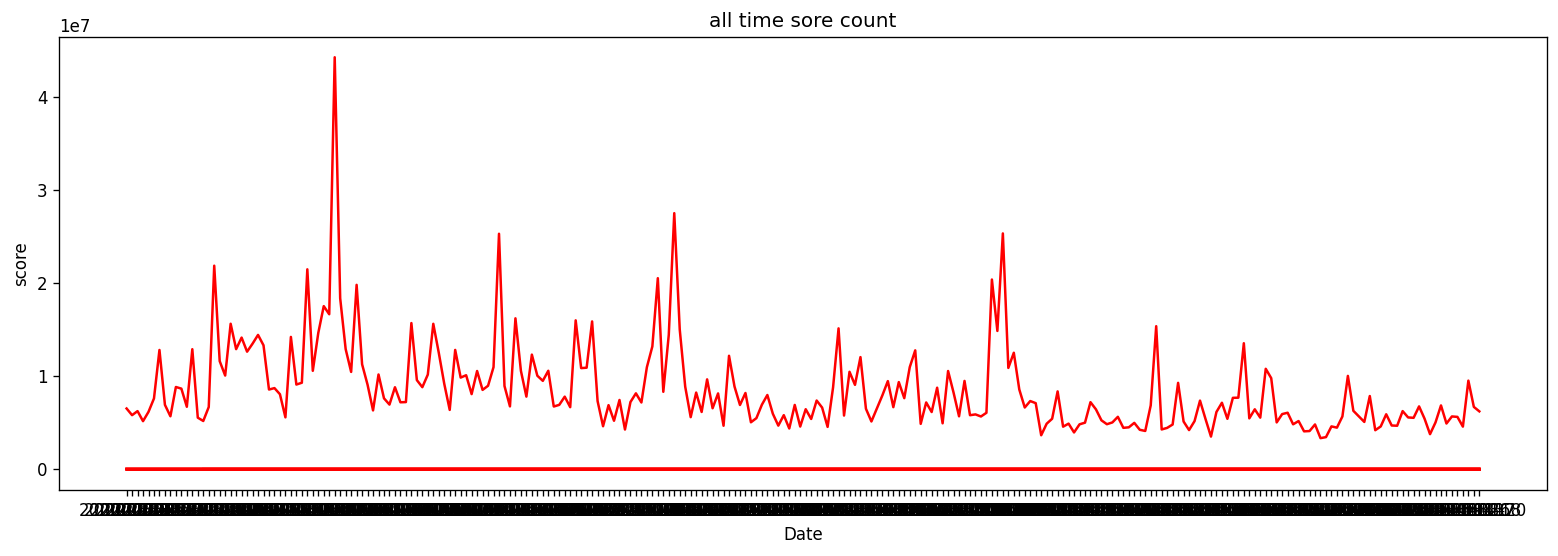

In [9]:
import matplotlib.pyplot as plt
def draw_ts_plot(timeseries, xlabel ='Date', ylabel ='totalScore', title ="", dpi=120):
    plt.figure(figsize=(16,5),dpi=dpi)
    plt.plot(timeseries, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

draw_ts_plot(data, xlabel="Date", ylabel = "score", title="all time sore count")

In [10]:
len(data)

248

In [11]:
# data.totalScore[33:]

In [12]:
# X for model 1
data.iloc[33:,:5]

,Open,High,Low,Close,Volume
Date,,,,,
2020-10-08,1090.000000,1124.000000,1088.400024,1093.699951,21482613
2020-10-09,1095.099976,1113.300049,1088.449951,1106.800049,10567867
2020-10-12,1123.000000,1140.000000,1112.099976,1132.099976,14633537
2020-10-13,1135.550049,1166.050049,1135.550049,1157.800049,17523825
2020-10-14,1162.000000,1164.900024,1131.099976,1137.000000,16649573
...,...,...,...,...,...
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,5612790
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,4564109
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,9510390


In [13]:
# Y for model 1
data.iloc[33:,5:-9]

,5EMA,26EMA,rsi,macd,macdSignal,macdHist
Date,,,,,,
2020-10-08,1061.145075,1009.566273,74.865337,35.519657,30.002912,5.516746
2020-10-09,1076.363410,1017.291250,76.605798,38.680122,31.738354,6.941768
2020-10-12,1094.942274,1026.363762,79.550869,42.733699,33.937423,8.796276
2020-10-13,1115.894872,1036.699085,82.026169,47.472732,36.644485,10.828248
2020-10-14,1122.929916,1044.550319,74.198005,48.985387,39.112665,9.872722
...,...,...,...,...,...,...
2021-08-13,1686.411299,1620.295316,81.019627,39.493425,35.186882,4.306544
2021-08-16,1692.407541,1626.525295,77.070625,40.126722,36.174850,3.951872
2021-08-17,1708.821702,1635.053053,81.666455,43.137119,37.567304,5.569816


In [15]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor1 = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
# x =Open	High	Low	Close	Volume
# y = 5EMA	26EMA	rsi	macd	macdSignal	macdHist
regressor1.fit(np.asarray(data.iloc[33:,:5]),data.iloc[33:,5:-9])

RandomForestRegressor(random_state=0)

In [16]:
# y = 5EMA	26EMA	rsi	macd	macdSignal	macdHist
# test
regressor1.predict(np.array([[1729.000000,1755.500000,1727.000000,	1733.449951,6686090]]))

array([[1714.37257798, 1641.23491116,   78.28470618,   43.79897037,
          38.7344813 ,    5.06448907]])

In [17]:
# x for model 2
data.iloc[33:,5:-9]

,5EMA,26EMA,rsi,macd,macdSignal,macdHist
Date,,,,,,
2020-10-08,1061.145075,1009.566273,74.865337,35.519657,30.002912,5.516746
2020-10-09,1076.363410,1017.291250,76.605798,38.680122,31.738354,6.941768
2020-10-12,1094.942274,1026.363762,79.550869,42.733699,33.937423,8.796276
2020-10-13,1115.894872,1036.699085,82.026169,47.472732,36.644485,10.828248
2020-10-14,1122.929916,1044.550319,74.198005,48.985387,39.112665,9.872722
...,...,...,...,...,...,...
2021-08-13,1686.411299,1620.295316,81.019627,39.493425,35.186882,4.306544
2021-08-16,1692.407541,1626.525295,77.070625,40.126722,36.174850,3.951872
2021-08-17,1708.821702,1635.053053,81.666455,43.137119,37.567304,5.569816


In [18]:
# Y for total score
data.totalScore[33:]

Date
2020-10-08    3
2020-10-09    4
2020-10-12    5
2020-10-13    3
2020-10-14    4
             ..
2021-08-13    3
2021-08-16    4
2021-08-17    5
2021-08-18    4
2021-08-20    5
Name: totalScore, Length: 215, dtype: int64

In [19]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
# x =  5EMA	26EMA	rsi	macd	macdSignal	macdHist 
# y = total score
regressor.fit(np.asarray(data.iloc[33:,5:-9]),data.totalScore[33:])

RandomForestRegressor(random_state=0)

In [21]:
#final
# x = Open	High	Low	Close	Volume
# y = total score
a = np.array([1703.900024,1748.900024	,1686.550049	,1741.650024	,9510390])
regressor.predict(regressor1.predict([a]))

array([4.28])